In [29]:
import pandas as pd
import requests
from io import BytesIO
import sqlite3
import os
import urllib3
from urllib3.exceptions import InsecureRequestWarning
import matplotlib.pyplot as plt
import seaborn as sns

urllib3.disable_warnings(InsecureRequestWarning)

# Function to download CSV from URL
def download_csv(url, headers=None):
    response = requests.get(url, headers=headers, verify=False)
    response.raise_for_status()
    df = pd.read_csv(BytesIO(response.content), encoding='latin1', delimiter=';')
    return df

# Function to save DataFrame to SQLite
def save_to_sqlite(df, table_name, db_path):
    os.makedirs(os.path.dirname(db_path), exist_ok=True)
    print(f"Saving to SQLite DB at path: {db_path}")
    conn = sqlite3.connect(db_path)
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    conn.close()

In [30]:
csv_url_1 = 'https://daten.transparenz.hamburg.de/Dataport.HmbTG.ZS.Webservice.GetRessource100/GetRessource100.svc/f565c684-2c98-4c61-982d-c1ec7ec2cade/Natural_Mineralwater.csv'
csv_url_2 = 'https://daten.transparenz.hamburg.de/Dataport.HmbTG.ZS.Webservice.GetRessource100/GetRessource100.svc/fa8ce806-e088-4bfb-9aa8-87c5c61807b1/Babynahrung_Gemuese_und_Huehnchen_mit_Nudeln.csv'

sqlite_db_path = os.path.join('../data', 'cleaned_data.db')
print(f"SQLite DB Path: {sqlite_db_path}")

# Download data
df1 = download_csv(csv_url_1)
df2 = download_csv(csv_url_2)

# Data cleaning
df1['Ergebnis'] = df1['Ergebnis'].replace('n.n.', 0).str.replace(',', '.').astype(float)
df1 = df1.drop(columns=['Probenahme-Beginn Zeit', 'Probenahme-Ende Zeit', 'Umweltbereich', 'Herkunftsstaat'])

df2['Ergebnis'] = df2['Ergebnis'].replace('n.n.', 0).str.replace(',', '.').astype(float)
df2 = df2.drop(columns=['Probenahme-Beginn Zeit', 'Probenahme-Ende Zeit', 'Umweltbereich', 'Herkunftsstaat'])

# Save cleaned data to SQLite
save_to_sqlite(df1, 'natural_mineralwater', sqlite_db_path)
save_to_sqlite(df2, 'babynahrung_gemuese_und_huehnchen_mit_nudeln', sqlite_db_path)


SQLite DB Path: ../data/cleaned_data.db
Saving to SQLite DB at path: ../data/cleaned_data.db
Saving to SQLite DB at path: ../data/cleaned_data.db


In [31]:
def read_from_sqlite(db_path, table_name):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql(f"SELECT * FROM {table_name}", conn)
    conn.close()
    return df

# Read data from the database
df_baby_food = read_from_sqlite(sqlite_db_path, 'babynahrung_gemuese_und_huehnchen_mit_nudeln')
df_mineral_water = read_from_sqlite(sqlite_db_path, 'natural_mineralwater')

# Display the first few rows of the dataframes
print("Baby Food Data:")
print(df_baby_food.head())
print("\nNatural Mineral Water Data:")
print(df_mineral_water.head())


Baby Food Data:
   Hauptprobenummer                                 Bezeichnung  \
0         202400080  Babynahrung Gemüse und Hühnchen mit Nudeln   
1         202400080  Babynahrung Gemüse und Hühnchen mit Nudeln   
2         202400080  Babynahrung Gemüse und Hühnchen mit Nudeln   
3         202400080  Babynahrung Gemüse und Hühnchen mit Nudeln   
4         202400080  Babynahrung Gemüse und Hühnchen mit Nudeln   

  Probe-Entnahmeart Probenahme-Beginn Datum Probenahme-Ende Datum  \
0       Einzelprobe              13.03.2024            13.03.2024   
1       Einzelprobe              13.03.2024            13.03.2024   
2       Einzelprobe              13.03.2024            13.03.2024   
3       Einzelprobe              13.03.2024            13.03.2024   
4       Einzelprobe              13.03.2024            13.03.2024   

         Messprogrammgruppe               Entnahmestelle  \
0  IMIS Routinemessprogramm  Groß-/Einzelhandel (Inland)   
1  IMIS Routinemessprogramm  Groß-/Einzelhande

In [32]:
print("\nBasic statistics for Baby Food Data:")
print(df_baby_food.describe())


Basic statistics for Baby Food Data:
       Hauptprobenummer    Ergebnis
count              55.0      2.0000
mean        202400080.0  45015.9500
std                 0.0  63617.0536
min         202400080.0     31.9000
25%         202400080.0  22523.9250
50%         202400080.0  45015.9500
75%         202400080.0  67507.9750
max         202400080.0  90000.0000


In [33]:
print("\nBasic statistics for Natural Mineral Water Data:")
print(df_mineral_water.describe())


Basic statistics for Natural Mineral Water Data:
       Hauptprobenummer  Ergebnis
count              32.0       1.0
mean        202400071.0  510000.0
std                 0.0       NaN
min         202400071.0  510000.0
25%         202400071.0  510000.0
50%         202400071.0  510000.0
75%         202400071.0  510000.0
max         202400071.0  510000.0


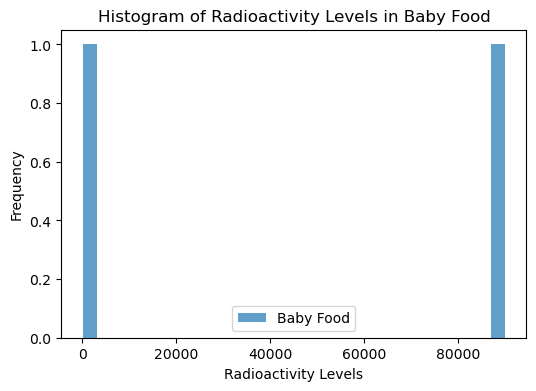

In [34]:
plt.figure(figsize=(6, 4))
plt.hist(df_baby_food['Ergebnis'].dropna(), bins=30, alpha=0.7, label='Baby Food')
plt.xlabel('Radioactivity Levels')
plt.ylabel('Frequency')
plt.title('Histogram of Radioactivity Levels in Baby Food')
plt.legend()
plt.show()

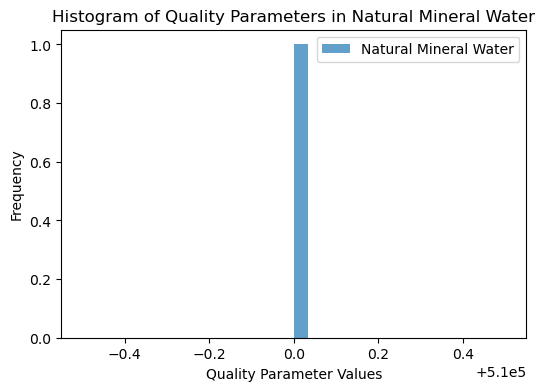

In [35]:
plt.figure(figsize=(6, 4))
plt.hist(df_mineral_water['Ergebnis'].dropna(), bins=30, alpha=0.7, label='Natural Mineral Water')
plt.xlabel('Quality Parameter Values')
plt.ylabel('Frequency')
plt.title('Histogram of Quality Parameters in Natural Mineral Water')
plt.legend()
plt.show()

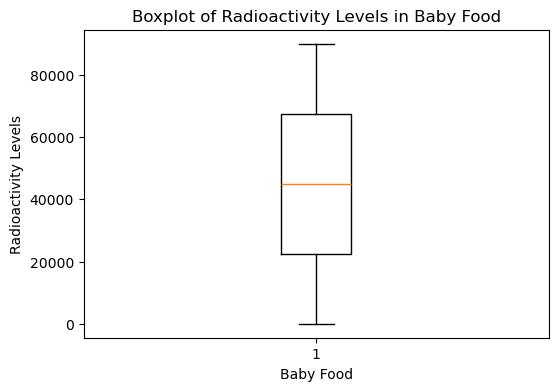

In [36]:
plt.figure(figsize=(6, 4))
plt.boxplot(df_baby_food['Ergebnis'].dropna())
plt.xlabel('Baby Food')
plt.ylabel('Radioactivity Levels')
plt.title('Boxplot of Radioactivity Levels in Baby Food')
plt.show()

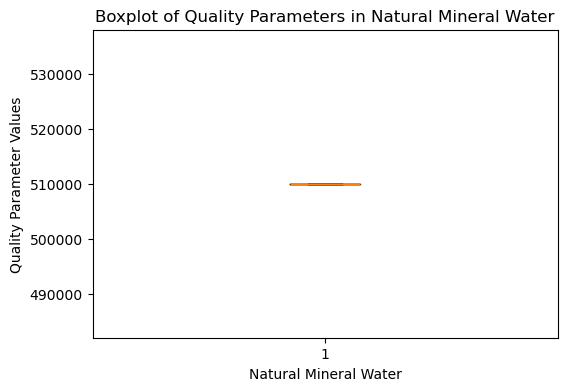

In [37]:
plt.figure(figsize=(6, 4))
plt.boxplot(df_mineral_water['Ergebnis'].dropna())
plt.xlabel('Natural Mineral Water')
plt.ylabel('Quality Parameter Values')
plt.title('Boxplot of Quality Parameters in Natural Mineral Water')
plt.show()

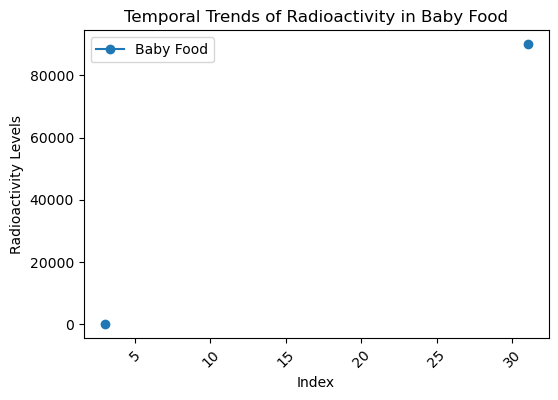

In [38]:
plt.figure(figsize=(6, 4))
plt.plot(df_baby_food.index, df_baby_food['Ergebnis'], 'o-', label='Baby Food')
plt.xlabel('Index')
plt.ylabel('Radioactivity Levels')
plt.title('Temporal Trends of Radioactivity in Baby Food')
plt.xticks(rotation=45)
plt.legend()
plt.show()

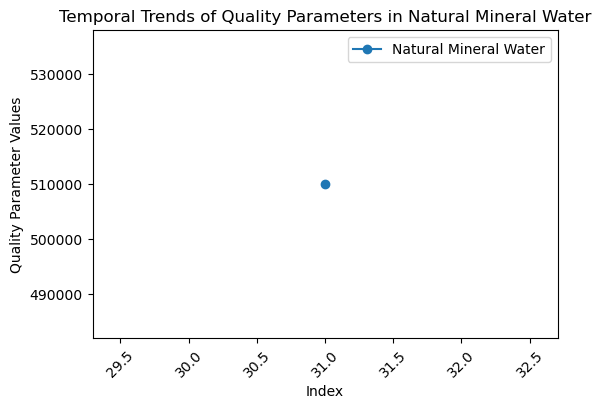

In [39]:
plt.figure(figsize=(6, 4))
plt.plot(df_mineral_water.index, df_mineral_water['Ergebnis'], 'o-', label='Natural Mineral Water')
plt.xlabel('Index')
plt.ylabel('Quality Parameter Values')
plt.title('Temporal Trends of Quality Parameters in Natural Mineral Water')
plt.xticks(rotation=45)
plt.legend()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


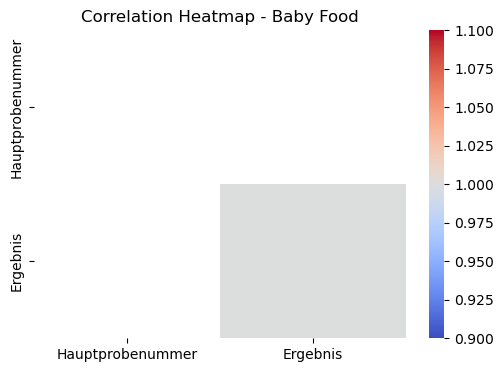

In [40]:
numeric_baby_food = df_baby_food.select_dtypes(include=[float, int])
correlation_baby_food = numeric_baby_food.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_baby_food, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap - Baby Food')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


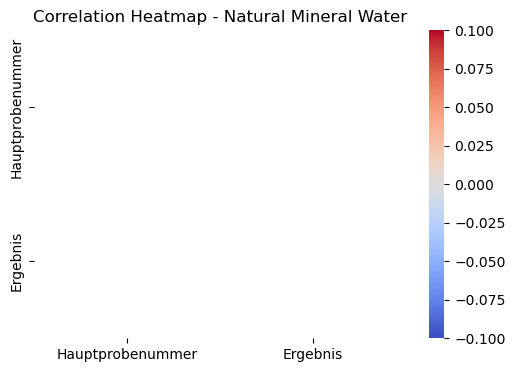

In [41]:
numeric_mineral_water = df_mineral_water.select_dtypes(include=[float, int])
correlation_mineral_water = numeric_mineral_water.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_mineral_water, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap - Natural Mineral Water')
plt.show()

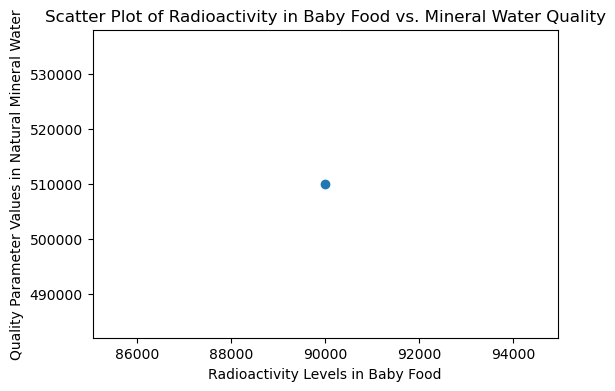

In [42]:
plt.figure(figsize=(6, 4))
combined_data = pd.merge(df_baby_food[['Ergebnis']], df_mineral_water[['Ergebnis']], left_index=True, right_index=True, suffixes=('_baby_food', '_mineral_water'))
plt.scatter(combined_data['Ergebnis_baby_food'], combined_data['Ergebnis_mineral_water'])
plt.xlabel('Radioactivity Levels in Baby Food')
plt.ylabel('Quality Parameter Values in Natural Mineral Water')
plt.title('Scatter Plot of Radioactivity in Baby Food vs. Mineral Water Quality')
plt.show()

# Results and Limitations

## Results
The analysis of the radioactivity levels in baby food and the quality parameters of natural mineral water in Hamburg revealed several key insights. The histograms and boxplots demonstrated the distribution and spread of the radioactivity levels in baby food and the quality parameters in mineral water, indicating the presence of outliers and the general behavior of the data. Temporal trend analysis, using line plots, provided an understanding of how these parameters changed over time, revealing any patterns or anomalies within the data. The correlation heatmaps illustrated the relationships between various numeric variables within each dataset, while the scatter plot suggested potential correlations between the radioactivity levels in baby food and the quality parameters of natural mineral water. These visualizations collectively contribute to an improved understanding of the environmental quality and public health implications in the Hamburg region.

## Limitations
1. **Data Limitations**:
   - **Missing Data**: The datasets had instances of missing values marked as 'n.n.', which were replaced with zeros. This imputation could potentially skew the results, as zero may not accurately reflect the true missing values.
   - **Data Consistency**: There might be inconsistencies in the data collection methods and reporting standards across the different datasets. These variations can introduce biases and affect the comparability of the results.

2. **Result Limitations**:
   - **Limited Variables**: The analysis primarily focused on the 'Ergebnis' column for both datasets. This may not capture all the relevant aspects of food and water quality, thus limiting the comprehensiveness of the findings.
   - **Temporal Scope**: The analysis of temporal trends was constrained by the availability and completeness of data over time. Incomplete or sparse time-series data could hinder the identification of long-term trends and patterns, thereby limiting the depth of the temporal analysis.

These limitations highlight the need for more comprehensive and consistent data collection practices and the inclusion of additional relevant variables to enhance the robustness and reliability of future analyses.
